### Load the required modules

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo
import pandas as pd
import my_functions as my
import numpy as np
import gsw

import my_plot_params

### Figure 1
---

Map of the deployment location, sea ice distribution, sea ice hovmoller

Sea ice data source: http://data.meereisportal.de/data/iup/hdf/s/

Data downloaded is the daily files from 01/07/2018 to 31/03/2018

---

First step is to process the `.hdf` sea ice data from the curvilinear grid to a linear grid (so we can calculate the hovmoller), then put it in an `xarray DataArray` and save as a `netCDF` for easy handling down the line

In [2]:
import seaice_funcs as si

dataPath= '/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/data/seaice/AMSR2_daily/'
outPath = '/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/data/seaice/'
outName = 'sic_interp_v2.nc'

# si.process_AMSR2(dataPath=dataPath, outPath=outPath, outName=outName)

Now we can load in the processed data

In [3]:
sic = xr.open_dataset(outPath+outName)

### Frontal detection 

Using the methods of Swart et al. (2010) An altimetry-based gravest empirical mode south of Africa: 1. Development and validation (Figure 8)

#### Load the absolute dynamic topography for the frontal locations 

In [4]:
print('Starting...')

adt = xr.open_mfdataset('/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/data/adt/nrt*.nc')

print('ADT loaded...')

# adjust the longitudes from (0, 360) to (-180, 180)
adt = my.adjust_lon_xr_dataset(adt, lon_name='longitude')

print('Longitue adjusted, now calculating gos...')

# get the mean adt for the deployment
adt_mean = adt.mean(dim='time')
adt_mean['gos'] = (('latitude', 'longitude'), np.sqrt(adt_mean.ugos**2 + adt_mean.vgos**2).data)

print('Starting EKE calculation...')

# calculate the eke
eke = my.calc_eke(adt)

print('Completed.')

Starting...
ADT loaded...
Longitue adjusted, now calculating gos...
Starting EKE calculation...
Completed.


/Users/xduplm/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/xduplm/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/xduplm/

In [5]:
# determine grid disances along 0E
dist_adt  = gsw.distance(np.zeros(len(adt_mean.latitude)), adt_mean.latitude.values)[0]
adt_slope = adt_mean.sel(longitude=0.125).adt.diff(dim='latitude') / dist_adt

### Plot Southern Ocean Fronts

Text(0.5, 1.0, '')

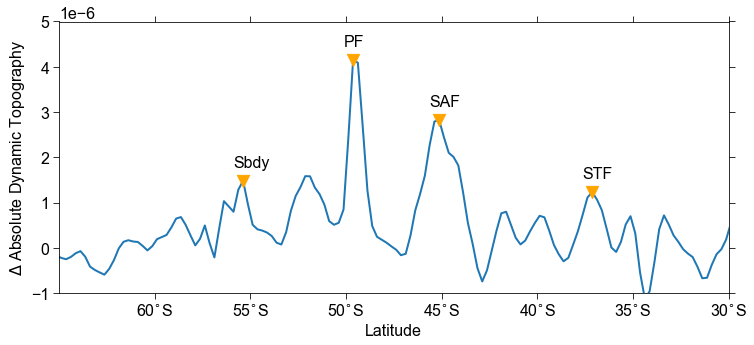

In [6]:
fig,ax=plt.subplots(figsize=[12, 5])

adt_slope.plot(ax=ax)
ax.set_xlim(-65, -30)
ax.set_ylim(-1e-6, 5e-6)

# idx = [137, 150, 160, 178, 210]
idx = [137, 160, 178, 210]
# fnt = ['Sbdy', 'sACCf', 'PF', 'SAF', 'STF']
fnt = ['Sbdy', 'PF', 'SAF', 'STF']

for i, val in enumerate(idx):

    front = adt_slope.isel(latitude=val)
    ax.scatter(front.latitude, front.values, s=150, c='orange', marker='v', zorder=10)
    ax.text(   front.latitude - 0.5,  front.values+3e-7, str(fnt[i]))

# plotting 
ax.xaxis.set_ticks([-60, -55, -50, -45, -40, -35, -30])
ax.xaxis.set_ticklabels(['60$^{\circ}$S','55$^{\circ}$S','50$^{\circ}$S','45$^{\circ}$S','40$^{\circ}$S','35$^{\circ}$S','30$^{\circ}$S'])

ax.set_ylabel('$\Delta$ Absolute Dynamic Topography')
ax.set_xlabel('Latitude')

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_title('')

# savefig('../figures/adt_grad_front_detection.png', dpi=300, bbox_inches='tight')

In [7]:
front_contours = adt_mean.adt.sel(longitude=0.125)[idx].values

### Determine sea ice max contour

In [8]:
# interpolate to monthly resolution
sic_mnth=sic.sic.resample(time='1M').mean()

/Users/xduplm/opt/anaconda3/lib/python3.9/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


(-20.0, 20.0)

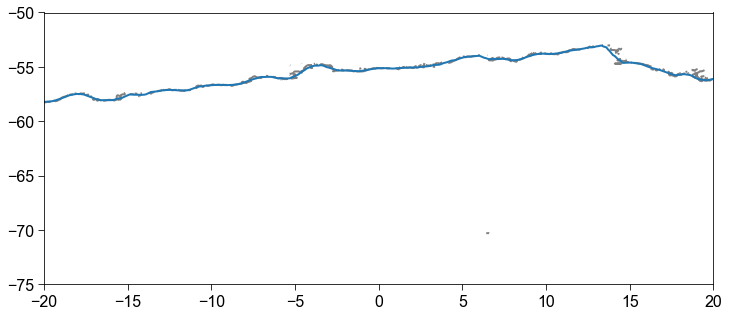

In [9]:
fig,ax=plt.subplots(figsize=[12,5])

cs = ax.contour(sic.lon, sic.lat, sic_mnth.sel(time='2018-09-30'), levels=[15], colors='0.5', linewidths=2)

for i in range(len(cs.allsegs[0])):
    
    if i==0:
        lon=cs.allsegs[0][i][:,0]
        lat=cs.allsegs[0][i][:,1]
        
    if i>0:
        lon = np.append(lon, cs.allsegs[0][i][:,0])
        lat = np.append(lat, cs.allsegs[0][i][:,1])

lon = lon[lat>-66]
lat = lat[lat>-66]
        
new_lon = np.arange(-180,180.05,0.1)
        
for i, ln in enumerate(new_lon):
    
    idx = ((lon>ln) & (lon<ln+0.1))
    
    if i==0:
        new_lat = np.median(lat[idx])
    if i>0:
        try:
            new_lat = np.append(new_lat, np.min(lat[idx]))
        except:
            new_lat = np.append(new_lat, np.nan)

import glidertools as gt

new_lat = gt.cleaning.rolling_window(new_lat, func=np.nanmean, window=10)

ax.plot(new_lon, new_lat)

ax.set_xlim(-20, 20)

# Find the fronts

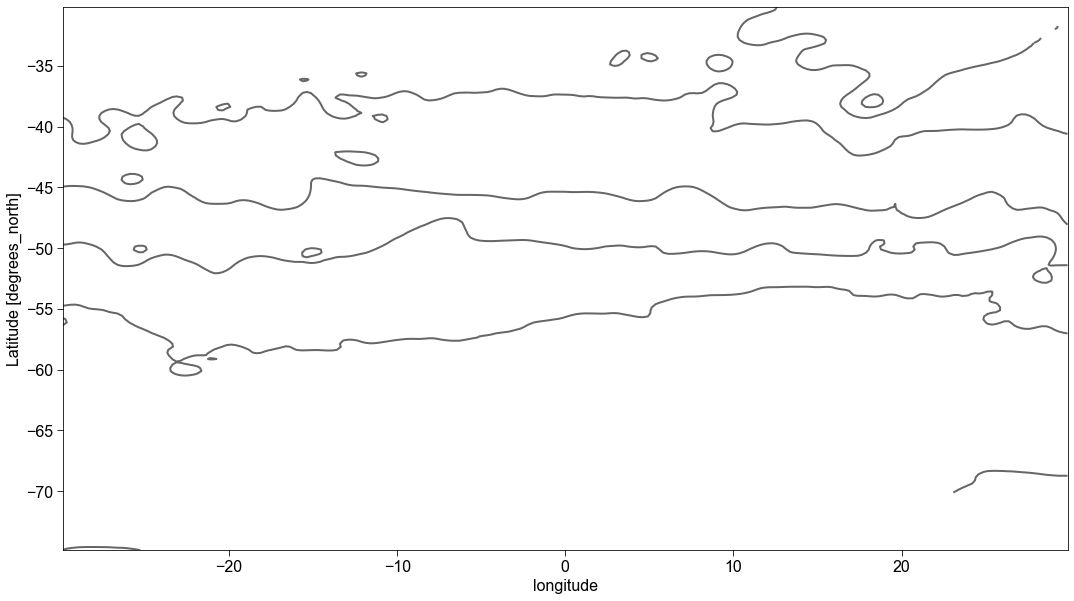

In [10]:
cs = adt_mean.adt.sel(longitude=slice(-30, 30), latitude=slice(-75,-30)).plot.contour(levels=front_contours, 
                                                                                      colors='0.4', 
                                                                                      linewidths=2, 
                                                                                      linestyles='-'
                                                                                     )
sbdy_lon=cs.allsegs[0][3][:,0]
sbdy_lat=cs.allsegs[0][3][:,1]

pf_lon=cs.allsegs[1][0][:,0]
pf_lat=cs.allsegs[1][0][:,1]

saf_lon=cs.allsegs[2][0][:,0]
saf_lat=cs.allsegs[2][0][:,1]

stf_lon=cs.allsegs[3][0][:,0]
stf_lat=cs.allsegs[3][0][:,1]

In [11]:
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 22}

plt.rc('font', **font)

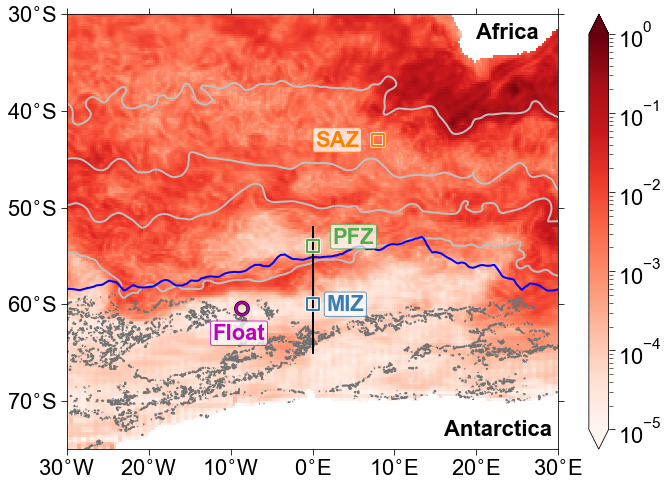

In [12]:
from matplotlib.colors import LogNorm

fig,ax=plt.subplots(figsize=[11,8])

h_sp = eke.plot.pcolormesh(norm=LogNorm(vmin=1e-5, vmax=1e-0), cmap='Reds')

ax.plot(stf_lon,  stf_lat,  c='0.75', lw=2)
ax.plot(saf_lon,  saf_lat,  c='0.75', lw=2)
ax.plot(pf_lon,   pf_lat,   c='0.75', lw=2)
ax.plot(sbdy_lon, sbdy_lat, c='0.75', lw=2)
# h_fr = adt_mean.adt.plot.contour(levels=front_contours, colors='0.4', linewidths=2, linestyles='-')

h_si = ax.plot(new_lon, new_lat, color='b', linewidth=2)
h_si = sic.sel(time='2018-12-14').sic.plot.contour(levels=[15], colors='0.45', linewidths=2)

ax.plot([0, 0], [-65, -52], c='k', lw=2)

clrs = ['#ff7f00', '#4daf4a', '#377eb8']

ax.scatter([8, 0, 0], [-43, -54, -60], s=150, marker='s', facecolor='none', edgecolor='w', zorder=100, linewidth=3.5)

ax.scatter(8, -43, s=150, marker='s', facecolor='none', edgecolor=clrs[0], zorder=100, linewidth=2)
ax.scatter(0, -54, s=150, marker='s', facecolor='none', edgecolor=clrs[1], zorder=100, linewidth=2)
ax.scatter(0, -60, s=150, marker='s', facecolor='none', edgecolor=clrs[2], zorder=100, linewidth=2)

ax.scatter([-8.63], [-60.45,], s=150, marker='o', facecolor='none', edgecolor='k',    zorder=80, linewidth=3.5)
ax.scatter([-8.63], [-60.45,], s=150, marker='o', facecolor='none', edgecolor='m', zorder=90, linewidth=2)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlim(-30, 30)
ax.set_ylim(-75, -30)

ax.xaxis.set_ticks([-30, -20, -10, 0, 10, 20, 30])
ax.xaxis.set_ticklabels(['30$^{\circ}$W','20$^{\circ}$W','10$^{\circ}$W','0$^{\circ}$E','10$^{\circ}$E','20$^{\circ}$E','30$^{\circ}$E'])

ax.yaxis.set_ticks([-70, -60, -50, -40, -30])
ax.yaxis.set_ticklabels(['70$^{\circ}$S','60$^{\circ}$S','50$^{\circ}$S','40$^{\circ}$S','30$^{\circ}$S'])

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

props = dict(boxstyle='round', facecolor='0.5', edgecolor='0.4', alpha=0.75, pad=0.1)
text_props = dict(ha='center', va='center', fontweight='bold')

ax.text(3, -43,  'SAZ',  c=clrs[0], **text_props, bbox=dict(boxstyle='round', facecolor='w', edgecolor=clrs[0], alpha=0.75, pad=0.1))
ax.text(5, -53,  'PFZ',  c=clrs[1], **text_props, bbox=dict(boxstyle='round', facecolor='w', edgecolor=clrs[1], alpha=0.75, pad=0.1))
ax.text(4, -60,  'MIZ',  c=clrs[2], **text_props, bbox=dict(boxstyle='round', facecolor='w', edgecolor=clrs[2], alpha=0.75, pad=0.1))
ax.text(-9, -63, 'Float',c='m',**text_props,  bbox=dict(boxstyle='round', facecolor='w', edgecolor='m' , alpha=0.75, pad=0.1))

ax.text(20, -32.5, 'Africa', c='k', fontweight='bold')
ax.text(16, -73.5, 'Antarctica', c='k', fontweight='bold')


plt.savefig('/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/figs_submission3/fig1a_map.png', dpi=300, bbox_inches='tight')

In [13]:
sic_merid = sic.sic.sel(lon=-1.0231815394945443e-11).load()

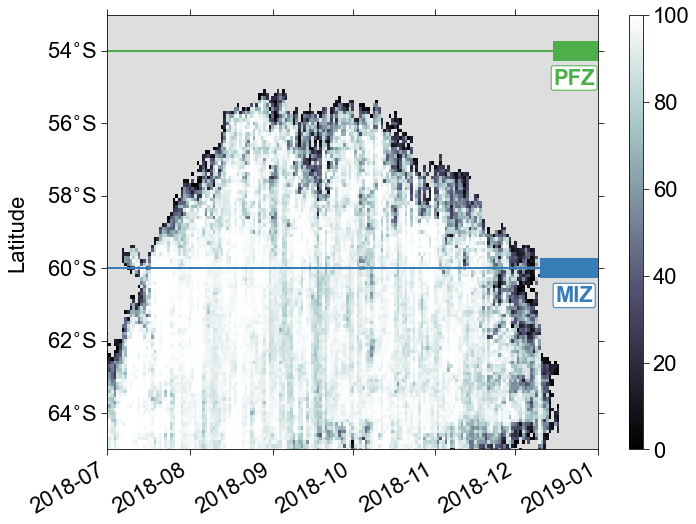

In [24]:
fig,ax=plt.subplots(figsize=[11, 8])

# plot the hovmoller
sic_merid.T.plot(cmap='bone', ax=ax, vmin=0, vmax=100, cbar_kwargs={'label': '', 'aspect': 30})

# # set the plot limits
ax.set_ylim(-65, -53)
ax.set_xlim(np.datetime64('2018-07-01'), np.datetime64('2019-01-01'))

ax.plot(sic_merid.time, np.zeros(len(sic_merid.time))-54, c=clrs[1], ls='-')
ax.plot(sic_merid.time, np.zeros(len(sic_merid.time))-60, c=clrs[2], ls='-')

ax.yaxis.set_ticks(np.arange(-64, -52, 2))
ax.yaxis.set_ticklabels(['64$^{\circ}$S', '62$^{\circ}$S', '60$^{\circ}$S', '58$^{\circ}$S', '56$^{\circ}$S', '54$^{\circ}$S'])

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Latitude', labelpad=20)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

d = pd.date_range(start='2018-12-19', end='2019-01-31',freq='1D')
ax.plot(d, np.zeros(len(d))-54, lw=20, c=clrs[1])

d = pd.date_range(start='2018-12-14', end='2019-01-31',freq='1D')
ax.plot(d, np.zeros(len(d))-60, lw=20, c=clrs[2])

# scatter(pd.to_datetime('2018-12-19T16:09:34'), -54, s=150, marker='s', facecolor='w', edgecolor='gold', lw=4, zorder=10)
# scatter(pd.to_datetime('2018-12-14T21:56:37'), -60, s=150, marker='s', facecolor='w', edgecolor='gold', lw=4, zorder=10)


props = dict(boxstyle='round', facecolor='0.5', edgecolor='0.4', alpha=0.75, pad=0.1)
text_props = dict(ha='center', va='center', fontweight='bold')

ax.text(pd.to_datetime('2018-12-23'), -54.75,  'PFZ',  c=clrs[1], **text_props, bbox=dict(boxstyle='round', facecolor='w', edgecolor=clrs[1], alpha=1, pad=0.1))
ax.text(pd.to_datetime('2018-12-23'), -60.75,  'MIZ',  c=clrs[2], **text_props, bbox=dict(boxstyle='round', facecolor='w', edgecolor=clrs[2], alpha=1, pad=0.1))

ax.plot([np.datetime64('2018-07-01'), np.datetime64('2019-01-01')], [-59, -59], c='0.75', zorder=0, lw=600, alpha=0.5)

plt.savefig('/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/figs_submission3/fig1b_seaice_hov.png', dpi=300, bbox_inches='tight')

### EN4 climatology figure

Using interpolated data from 2002-2019

In [16]:
en4=xr.open_mfdataset('/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/data/EN4/*.nc')

In [17]:
import my_functions as my

en4 = my.adjust_lon_xr_dataset(en4, lon_name='lon')
clim = en4.groupby('time.season').mean('time', keep_attrs=True).sel(season='DJF', lon=slice(-5, 10)).mean(dim='lon').sel(lat=slice(-70, -20))

/Users/marcel/opt/anaconda3/envs/duplessis2021_JGR/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/marcel/opt/anaconda3/envs/duplessis2021_JGR/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

In [18]:
clim['density'] = (('depth', 'lat'), gsw.rho(clim.salinity, clim.temperature-273.15, clim.depth/1000).data)

In [19]:
mld=my.calc_mld(clim.density.T, clim.depth)

In [20]:
clim = clim.sel(lat=slice(-63, -38), depth=slice(0, 1000)).load()

In [21]:
clim['temperature'] = clim['temperature']-273.15

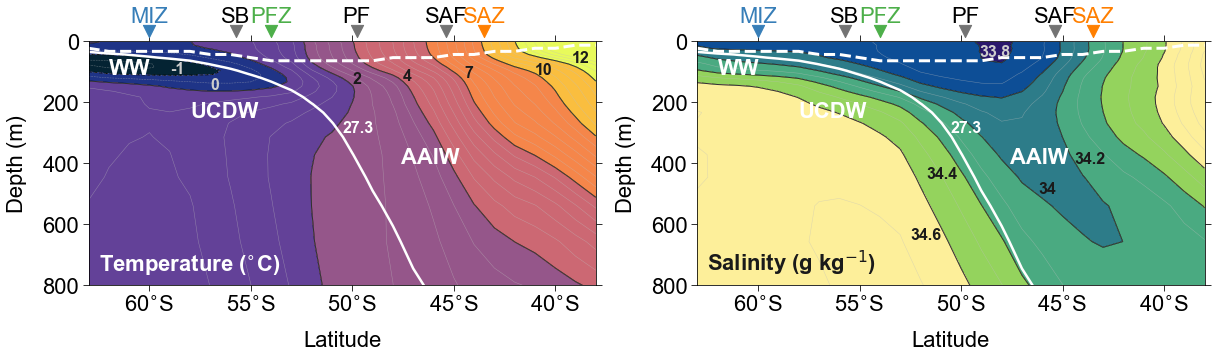

In [27]:
fig,ax = plt.subplots(1, 2, figsize=[20, 4.5])

sal_lbs = [33.8, 34, 34.2, 34.4, 34.6]
tmp_lbs = [-1, 0, 2, 4, 7, 10, 12]

clim.temperature.plot.contourf(ax=ax[0], cmap=cmo.thermal, 
                               levels=tmp_lbs,
                               add_colorbar=False
                              )
clim.salinity.plot.contourf(ax=ax[1], cmap=cmo.haline,  
                            levels=sal_lbs,
                            add_colorbar=False,
                           )

clim.temperature.plot.contour(ax=ax[0], colors='k', levels=tmp_lbs, linewidths=1)
clim.salinity.plot.contour(ax=ax[1],    colors='k', levels=sal_lbs, linewidths=1)

clim.temperature.plot.contour(ax=ax[0], colors='0.75', linewidths=0.5, levels=np.arange(-2, 14, 0.5), alpha=0.5)
clim.salinity.plot.contour(ax=ax[1],    colors='0.75', linewidths=0.5, levels=np.arange(33, 37, 0.1), alpha=0.5)

[a.contour(clim.lat, clim.depth, clim.density, levels=[1027.3], colors='w', linewidths=2.5) for a in ax]

mld=my.calc_mld(clim.density.T, clim.depth)
[a.plot(clim.lat, mld, c='w', ls='--', lw=3) for a in ax]

for a in ax:
    
    a.set_xlim(-63, -38)
    a.set_ylim(800, 0)
    a.set_title('')
    
    a.xaxis.set_ticks([-60, -55, -50, -45, -40])
    a.xaxis.set_ticklabels(['60$^{\circ}$S', '55$^{\circ}$S', '50$^{\circ}$S', '45$^{\circ}$S', '40$^{\circ}$S'])
    
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    
    a.set_ylabel('Depth (m)', labelpad=15)
    a.set_xlabel('Latitude', labelpad=15)
    
    gld = ['SAZ', 'PFZ', 'MIZ']
    
    for i, lt in enumerate([-43.5, -54, -60]):
    
        h=a.scatter(lt, -30, s=150, color=clrs[i], zorder=10, marker='v')
        h.set_clip_on(False)
        
        a.text(lt, -60, gld[i],
               c=clrs[i],
               ha='center'
              )
        
    frnt_lons = [saf_lon, pf_lon, sbdy_lon]
    frnt_lats = [saf_lat, pf_lat, sbdy_lat]
    fnt = ['SAF', 'PF', 'SB']
    
    for i, val in enumerate(frnt_lons):
        
        idx = np.argmin(np.abs(val))
        h=a.scatter(frnt_lats[i][idx], -30, 
                    s=150, color='0.45', 
                    zorder=10, marker='v'
                   )
        h.set_clip_on(False)   
        a.text(frnt_lats[i][idx], -60, fnt[i],
               ha='center'
              )

#         a.yaxis.set_ticks([400, 300, 200, 100, 0])

    a.text(-62, 110,  'WW',   c='w', fontweight='bold')
    a.text(-58, 250, 'UCDW', c='w', fontweight='bold')
    a.text(-47.6, 400, 'AAIW', c='w', fontweight='bold')
    a.text(-50.5, 300, '27.3', fontsize=16, fontweight='bold', c='w')
    
props=dict(fontsize=16, fontweight='bold')
    
ax[0].text(-59,   105, '-1', **props, c='0.8')
ax[0].text(-57,   160, '0',  **props, c='0.8')
ax[0].text(-50,   140, '2',  **props, c='0.1')
ax[0].text(-47.5, 130, '4',  **props, c='0.1')
ax[0].text(-44.5, 120, '7',  **props, c='0.1')
ax[0].text(-41,   110, '10', **props, c='0.1')
ax[0].text(-39.2,  70, '12', **props, c='0.1')

ax[1].text(-52.5, 650, '34.6',  **props, c='0.1')
ax[1].text(-51.7, 450, '34.4',  **props, c='0.1')
ax[1].text(-44.4, 400, '34.2',  **props, c='0.1')
ax[1].text(-46.2, 500, '34',    **props, c='0.1')
ax[1].text(-49.1, 50,  '33.8',  **props, c='0.8')

ax[0].text(-62.5, 750, 'Temperature ($^{\circ}$C)', c='w', fontweight='bold')
ax[1].text(-62.5, 750, 'Salinity (g kg$^{-1}$)', c='0.1', fontweight='bold')



plt.savefig('/Volumes/GoogleDrive/My Drive/Projects/duplessis-2021-SO-thermohaline/figs_submission2/fig1_sections.png', dpi=300, bbox_inches='tight')

In [32]:
np.argmin(np.abs(stf_lon))

225